In [1]:
from keras import models
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plot
import keras

Using TensorFlow backend.


In [2]:
model = load_model('cats_and_dogs_small1.h5')
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooli

In [3]:
img_path = '/home/labina/Lectures/AdvanceDeepLearning/datasets/train/cat.10001.jpg'
img = image.load_img(img_path, target_size=(150,150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0 )
img_tensor /=255
print(img_tensor.shape)

(1, 150, 150, 3)


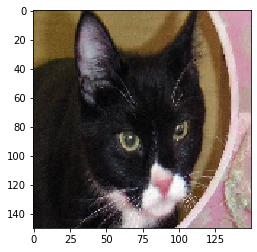

In [4]:
plot.imshow(img_tensor[0])
plot.show()

In [5]:
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs = model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)
first_layer_activation = activations[0]
print(first_layer_activation.shape)


(1, 148, 148, 32)


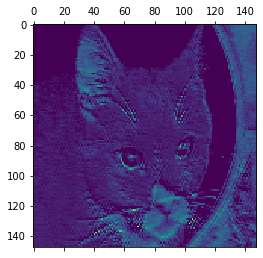

In [6]:
plot.matshow(first_layer_activation[0,:,:,3], cmap ='viridis')#3rd channel
plot.show()

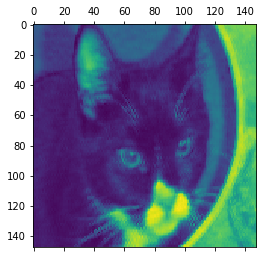

In [7]:
plot.matshow(first_layer_activation[0,:,:,30], cmap = 'viridis')#30th channel 
plot.show()

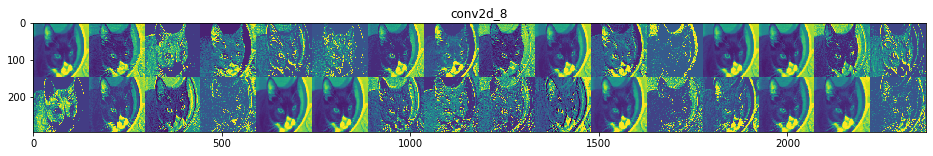

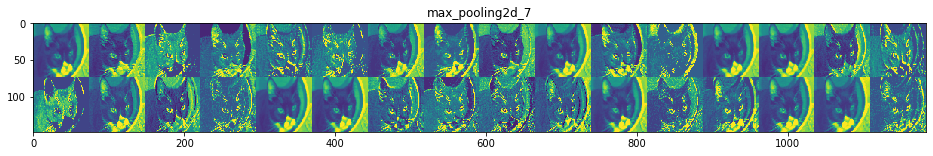

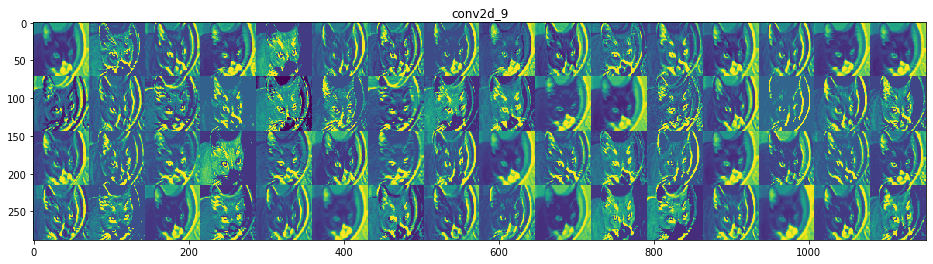

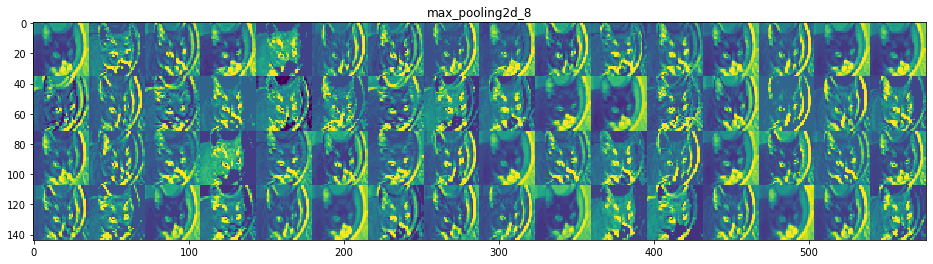

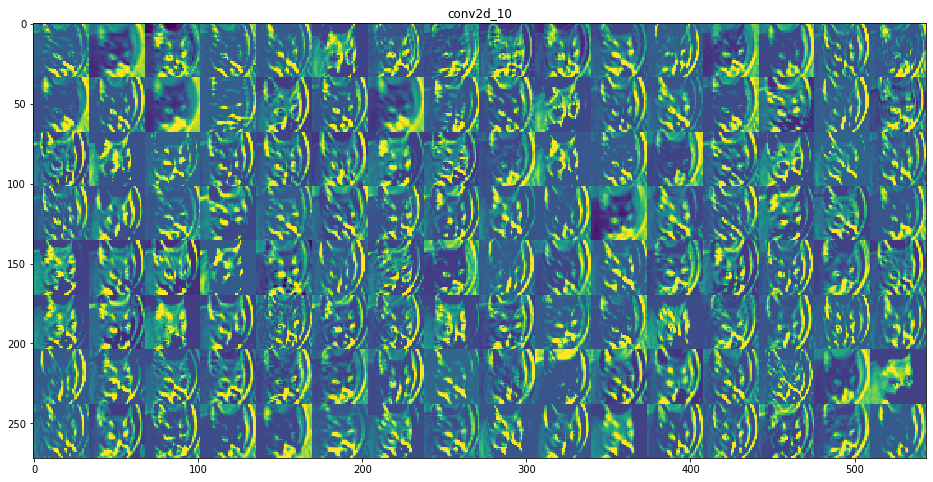

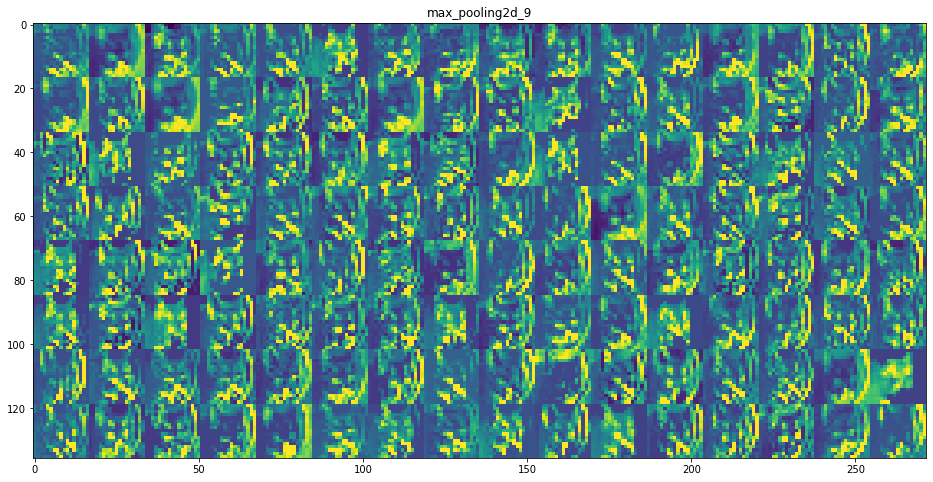

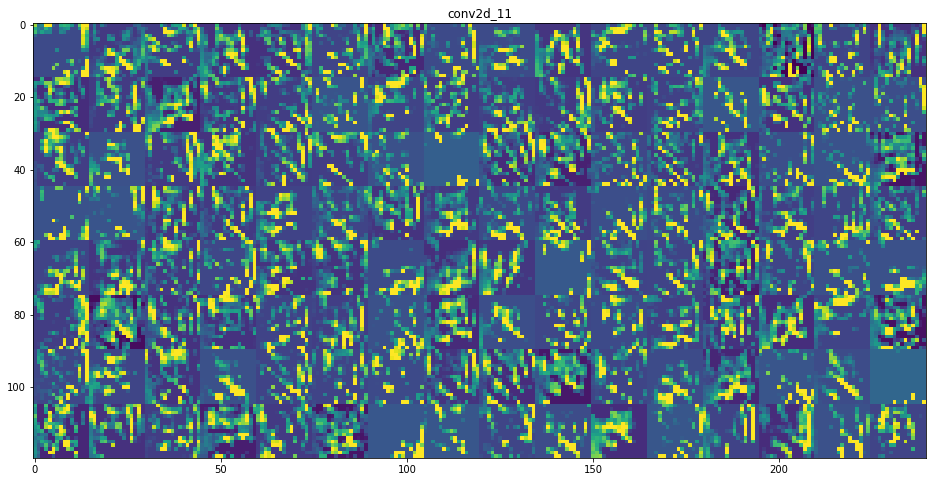

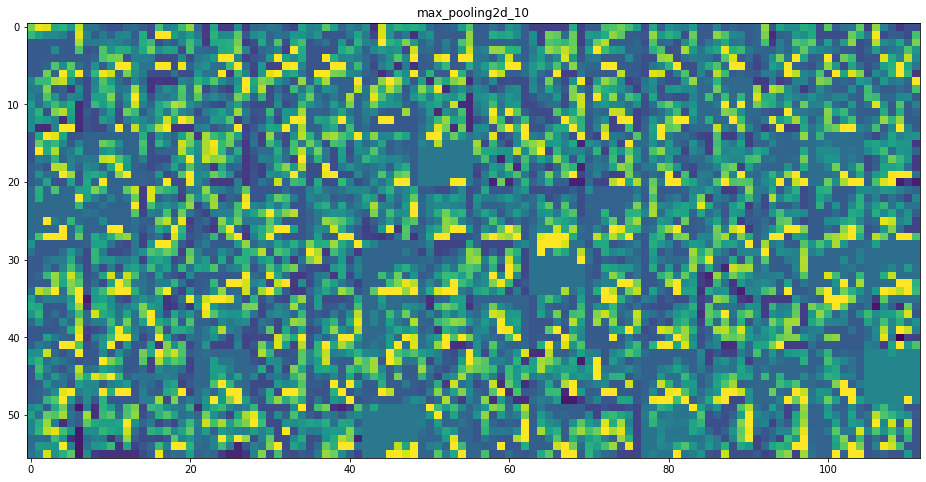

In [12]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
image_per_row = 16 

#display features maps
for layer_name, layer_activation in zip(layer_names, activations):
    # the numbers of features in the feature map 
    n_features = layer_activation.shape[-1]
    #shape of fratures 
    size = layer_activation.shape[1]
    n_cols = n_features // image_per_row
    display_grid = np.zeros((size*n_cols, image_per_row*size))
    #tile each filters into the big horizontal grid
    scale = 1./size
    plot.figure(figsize =(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
    for col in range(n_cols):
        for row in range(image_per_row):
            channel_image = layer_activation[0,
                                            :,:,col*image_per_row+row]
            #Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image,0,255).astype('uint8')
            display_grid[col * size : (col+1)*size,
                        row * size : (row+1)*size] = channel_image
        
        plot.title(layer_name)
        plot.grid(False)
        plot.imshow(display_grid, aspect = 'auto', cmap ='viridis')
plot.show()

### Visualizing convnet filters

In [13]:
from keras.applications import VGG16
from keras import backend as K 

model = VGG16(weights = 'imagenet',
             include_top =False)

layer_name = 'block3_conv1'
filter_index = 0 

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

grads = K.gradients(loss, model.input)[0]
grads /= (K.sqrt(K.mean(K.square(grads)))+ 1e-5)

In [14]:
iterate = K.function([model.input], [loss,grads])

loss_value, grads_value = iterate([np.zeros((1,150,150,3))])
#start from a gray image with some noise
input_img_data = np.random.random((1,150,150,3))*20+128
#run gradient asscent for 40 steps
step = 1
for i in range(40):
    #compute the loss value and gradient value
    loss_value, grads_value = iterate([input_img_data])
    #adjust the input image in the direction that maximizes the loss
    input_img_data += grads_value *step

In [15]:
def deprocess_image(x):
    #normalize tensor:center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    #clip to [0,1]
    x += 0.5
    x = np.clip(x, 0, 1)
    #convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x
    

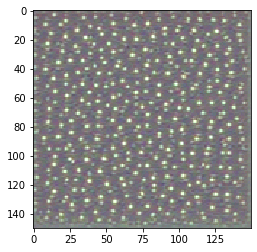

In [16]:
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    #compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]
    
    #Normalization trick:we normalize the gradient 
    grads /= (K.sqrt(K.mean(K.square(grads))) +1e-5)
    
    #function to return the loss and grads given the input picture
    iterate = K.function([model.input],[loss, grads])
    
    #we start from a gray image with some noise
    input_img_data = np.random.random((1,size,size,3)) *20 +128
    
    #run gradient ascent for 40 steps 
    step = 1
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step 
    img = input_img_data[0]
    return deprocess_image(img)

plot.imshow(generate_pattern('block3_conv1', 0))
plot.show()

###  Visualising every single filter in every layer

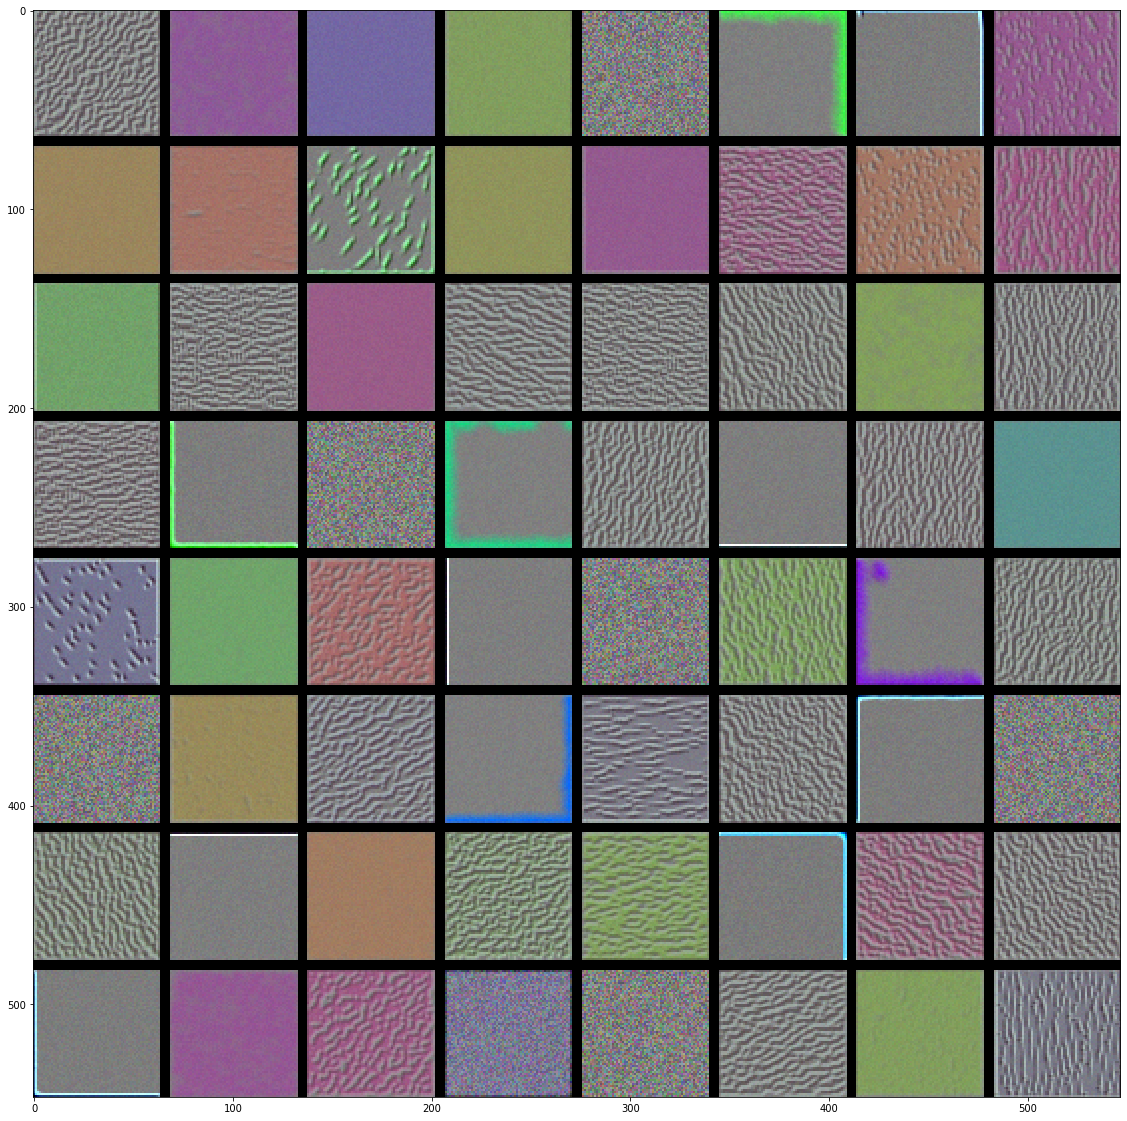

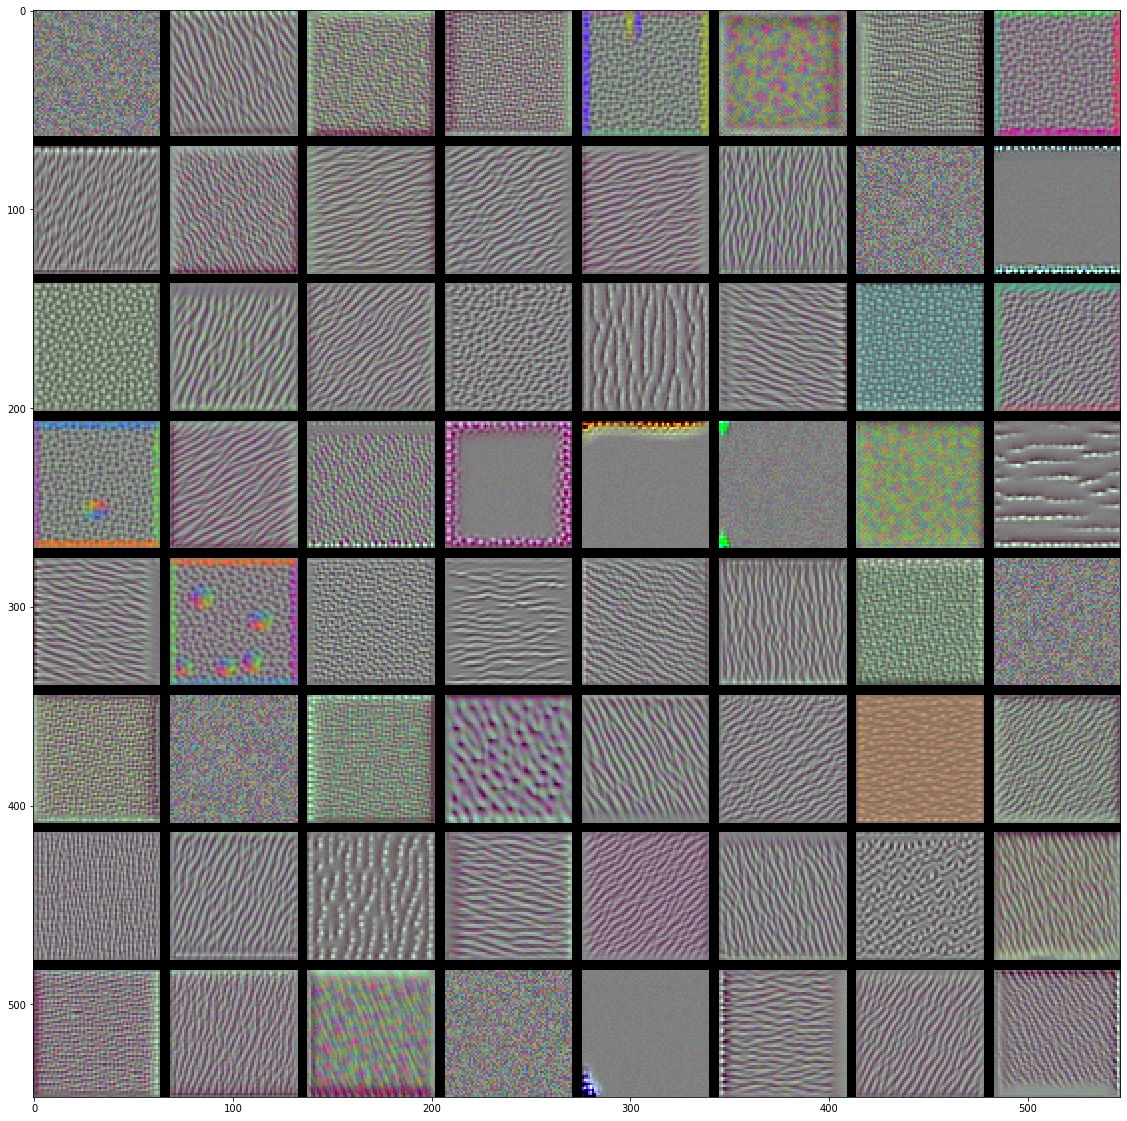

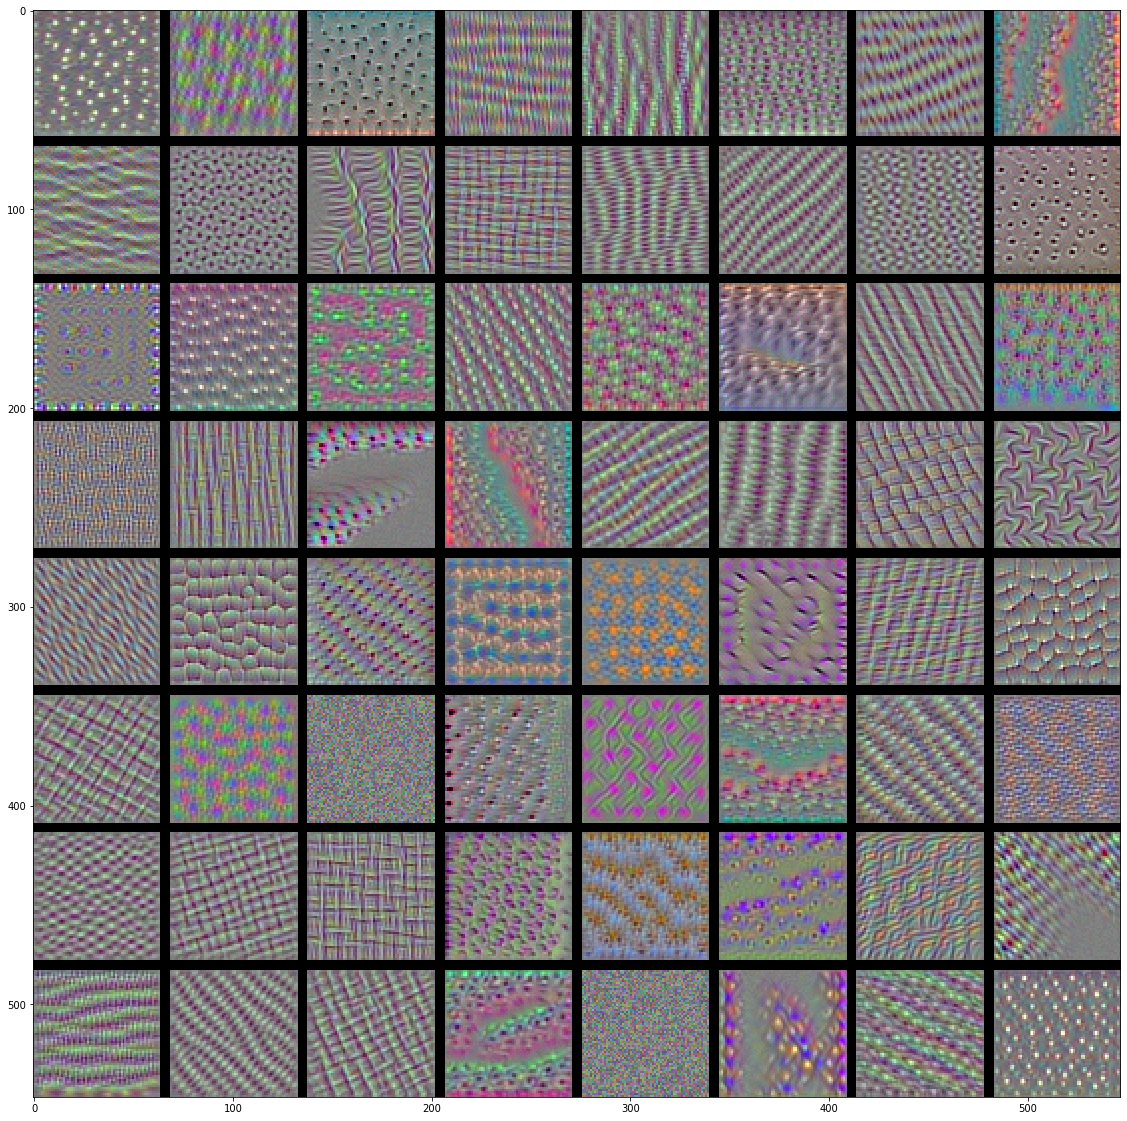

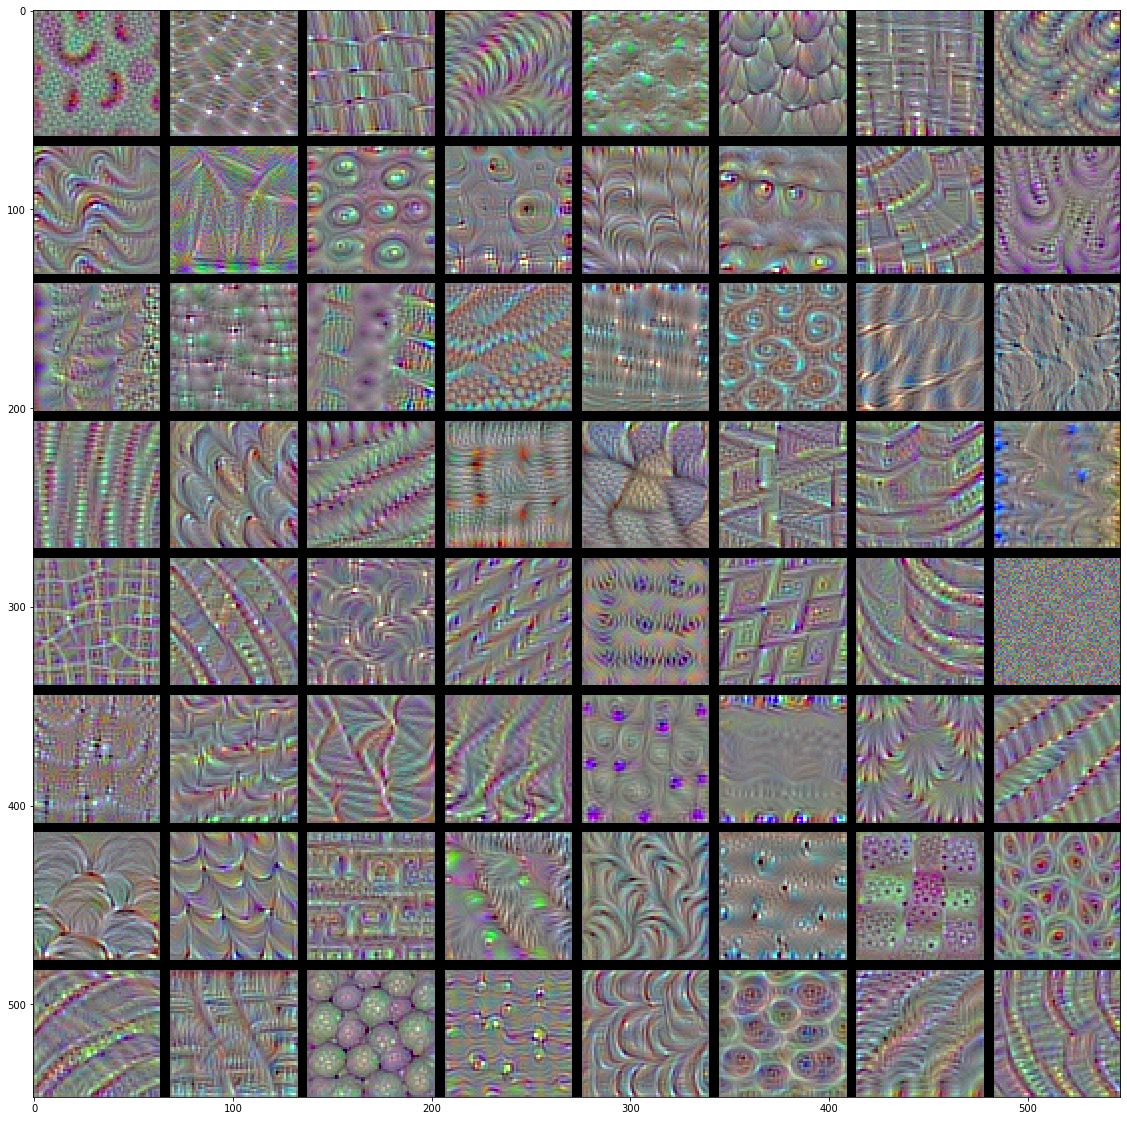

In [17]:
for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']:
    size = 64
    margin = 5

    # This a empty (black) image where we will store our results.
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    for i in range(8):  # iterate over the rows of our results grid
        for j in range(8):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plot.figure(figsize=(20, 20))
    plot.imshow(keras.preprocessing.image.array_to_img(results))
    plot.show()

###  Visualizing heatmaps of class activation

In [15]:
from keras.applications.vgg16 import VGG16 

K.clear_session()
model = VGG16(weights = 'imagenet')


In [16]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions

img_path = '/home/labina/Lectures/AdvanceDeepLearning/common_elephant.jpeg'
img = image.load_img(img_path, target_size =(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = preprocess_input(x)

In [17]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top = 3)[0])

Predicted: [('n02504458', 'African_elephant', 0.909421), ('n01871265', 'tusker', 0.086182885), ('n02504013', 'Indian_elephant', 0.0043545826)]


In [18]:
np.argmax(preds[0])

386

###  To visualize which part of image were the most "African elephant" 

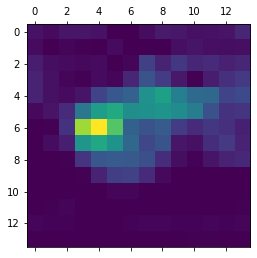

In [19]:
african_elephant_output = model.output[:, 386]
last_conv_layer = model.get_layer('block5_conv3')
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plot.matshow(heatmap)
plot.show()

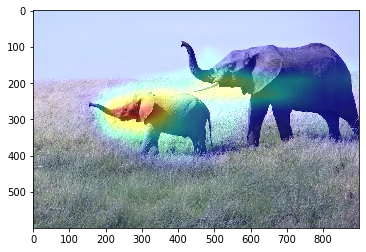

In [20]:
import cv2
#use cv2 to load the original image
img = cv2.imread(img_path)
#resize to have same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
#converting heatmap to RGB
heatmap = np.uint8(255 * heatmap)
#applying heatmap to original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
#0.4 = heatmap intensity factor
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('/home/labina/Lectures/AdvanceDeepLearning/datasets/elephant_cam.jpg', superimposed_img)
img = image.load_img('/home/labina/Lectures/AdvanceDeepLearning/datasets/elephant_cam.jpg')
plot.imshow(img)
plot.show()